In [1]:
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
import numpy as np

#always remember your magic function if using Jupyter
%matplotlib inline

pd.set_option('display.max_rows',30)
os.chdir('/Users/alexandrejacqueline/Data_Science/P3')

datas = pd.read_csv('cleaned_openfoodfacts.csv', sep='\t')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Analyse exploratoire des données¶

Après avoir nettoyé les données issues de la base OpenFoodFacts dans le notebook PSanté_01_nettoyage, nous avons exporté un nouveau dataset cleané que nous allons ici pouvoir analyser.

Nous réaliserons ici des analyses univariées, bivariées et multivariées ainsi qu'une réduction dimensionnelle.

In [2]:
datas.dtypes

code                            object
url                             object
creator                         object
created_datetime                object
last_modified_datetime          object
                                ...   
salt_100g                      float64
nutrition-score-fr_100g        float64
fruits-vegetables-rate_100g      int64
calc_global_score                int64
calc_nutriscore                 object
Length: 35, dtype: object

Suite au nettoyage effectué dans le Notebook précédent, les valeurs médianes, écarts-type et valeus max semblent être cohérentes compte tenu du volume de données.

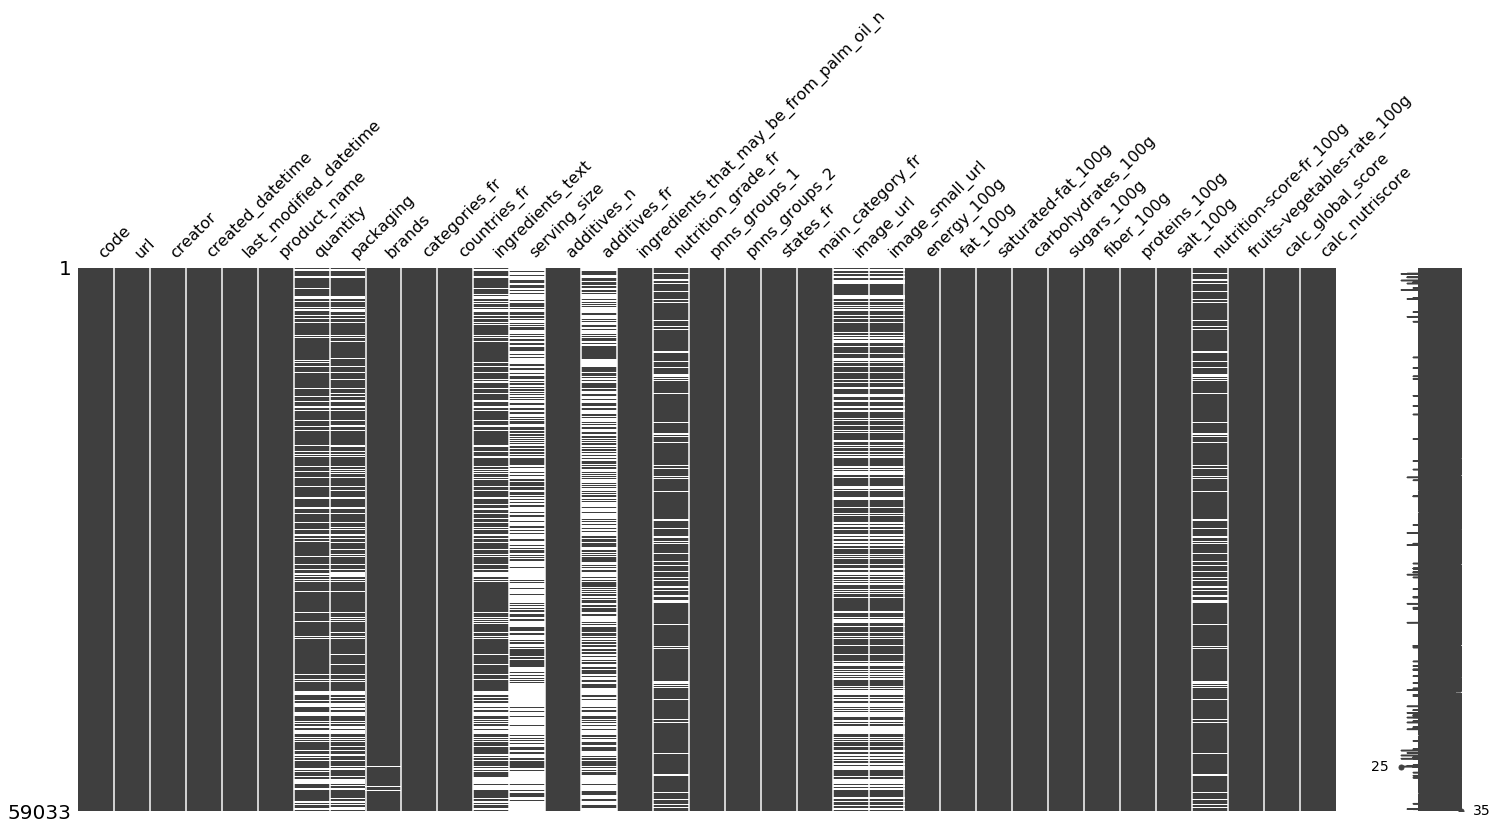

In [3]:
msno.matrix(datas)

In [4]:
datas.shape

(59033, 35)

In [7]:
datas.describe()

additives_n  ingredients_that_may_be_from_palm_oil_n   energy_100g  \
count  59102.000000                             59102.000000  59102.000000   
mean       1.525177                                 0.071537   1024.793606   
std        1.726361                                 0.257722    694.931046   
min        0.000000                                 0.000000      0.000000   
25%        0.000000                                 0.000000    406.000000   
50%        1.000000                                 0.000000    997.000000   
75%        2.000000                                 0.000000   1555.000000   
max        8.000000                                 1.000000   3305.000000   

           fat_100g  saturated-fat_100g  carbohydrates_100g   sugars_100g  \
count  59102.000000        59102.000000        59102.000000  59102.000000   
mean      11.338609            4.645801           24.452939     11.348018   
std       11.635764            5.993021           23.014907     14.680207   
min        0.000000            0.000000            0.000000      0.000000   
25%        1.600000            0.300000            5.900000      1.200000   
50%        7.900000            2.000000           20.600000      4.600000   
75%       18.140000            6.113500           37.000000     13.900000   
max       56.200000           26.400000           96.500000     61.000000   

         fiber_100g  proteins_100g     salt_100g  nutrition-score-fr_100g  \
count  59102.000000   59102.000000  59102.000000              52871.00000   
mean       1.857067       7.653646      0.857758                  7.96622   
std        2.286197       6.647219      1.070381                  8.98431   
min        0.000000       0.000000      0.000000                -14.00000   
25%        0.000000       2.500000      0.100000                  1.00000   
50%        1.100000       6.500000      0.660000                  6.00000   
75%        2.700000      10.400000      1.200000                 15.00000   
max       13.700000      29.100000     11.607800                 40.00000   

       fruits-vegetables-rate_100g  calc_global_score  
count                 59102.000000       59102.000000  
mean                     38.408954           7.256032  
std                      16.603752           8.621446  
min                      25.000000         -12.000000  
25%                      25.000000           1.000000  
50%                      45.000000           6.000000  
75%                      45.000000          13.000000  
max                      81.000000          30.000000

1.1. Analyse des dates de création et modification de produits

In [8]:
datas['created_datetime'] =pd.to_datetime(datas['created_datetime'], errors='coerce')

datas['last_modified_datetime'] =pd.to_datetime(datas['last_modified_datetime'], errors='coerce')


In [9]:
datas = datas[datas['created_datetime']>"2010"]

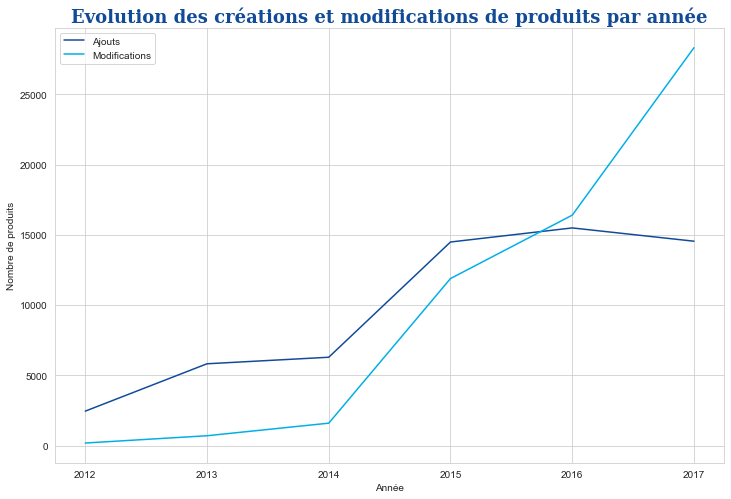

In [10]:
add_per_year = datas['code'].groupby(by=datas['created_datetime'].dt.year).nunique()
modified_per_year = datas['code'].groupby(by=datas['last_modified_datetime'].dt.year).nunique()

fig=plt.figure(figsize=(12,8))

font_title = {'family': 'serif',
              'color':  '#114b98',
              'weight': 'bold',
              'size': 18,
             }

sns.set_style("whitegrid")
plt.plot(add_per_year, 
         color="#114b98", 
         label="Ajouts")
plt.plot(modified_per_year, 
         color="#00afe6", 
         label="Modifications")
plt.title("Evolution des créations et modifications de produits par année", 
          fontdict=font_title)
plt.xlabel("Année")
plt.ylabel("Nombre de produits")
plt.legend()
plt.show()



On remarque que les ajouts dans la base OpenFoodFacts se sont accélérés à partir de 2012
. Les modifications de produits quant à elles se sont intensifiées nettement à partir de 2014 avec un pic pour le moment en 2020.


In [11]:
modified_products = round((datas[datas['last_modified_datetime'] > datas['created_datetime']].shape[0] / datas.shape[0])*100,2)
print("{:02}% des produits ont été modifiés au moins 1 fois depuis leur création.".format(modified_products))

89.38% des produits ont été modifiés au moins 1 fois depuis leur création.


# 1.2. Les contributeurs à la base OpenFoodFacts

Regardons à présent la répartition des entrées par contributeurs :

In [12]:
creators = datas.groupby(by='creator')['code'].nunique().sort_values(ascending=False)

In [13]:
def plot_contributor(n=5):
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(aspect="equal"))

    explodes = np.zeros(n)
    explodes[0] = .1

    def pct_tot(pct):
        tot = round(pct*creators[:n].sum(),0)
        tot_pct = tot/creators.sum()
        return "{:.1f}%\n({:.0f})".format(tot_pct,(tot/100))

    plt.pie(creators[:n], labels=creators[:n].index, 
            startangle=45, 
            shadow=True,
            explode=explodes,
            autopct=lambda pct: pct_tot(pct),
            textprops=dict(color="black",size=10, weight="bold"))
    plt.title("Qui sont les {:d} meilleurs contributeurs ?".format(n), 
              fontdict=font_title)
    plt.show()

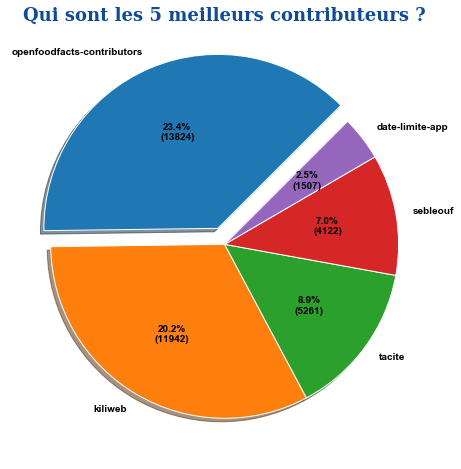

In [14]:
plot_contributor(n=5)

# 1.3. Répartition des Nutriscores et ANOVA

Nous avons tenté de calculer simplement les nutriscores et nutrigrades dans le Notebook P3-1. Cependant, les erreurs constatées étant supérieur à 50%, nous n'avons pas imputé les valeurs manquantes à cette étape. Regardons à présent la répartition des nutriscores déjà complétés dans le dataset initial :


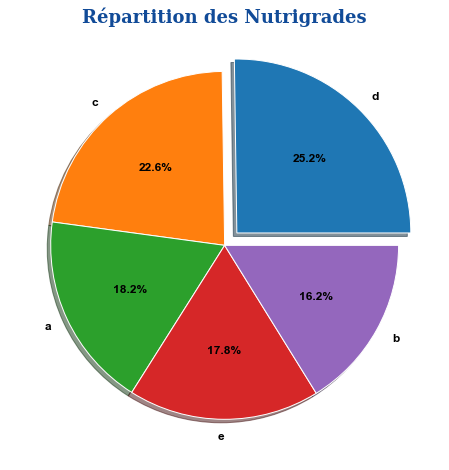

In [15]:
nutrigrades = datas.groupby(by='nutrition_grade_fr')['code'].nunique().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(aspect="equal"))

explodes = np.zeros(5)
explodes[0] = .1

plt.pie(nutrigrades, labels=nutrigrades.index, 
        startangle=0, 
        shadow=True,
        explode=explodes,
        autopct='%1.1f%%',
        textprops=dict(color="black",size=12, weight="bold"))
plt.title("Répartition des Nutrigrades", fontdict=font_title)
plt.show()



On peut également visualiser l'évolution des différents nutrigrades dans le temps :


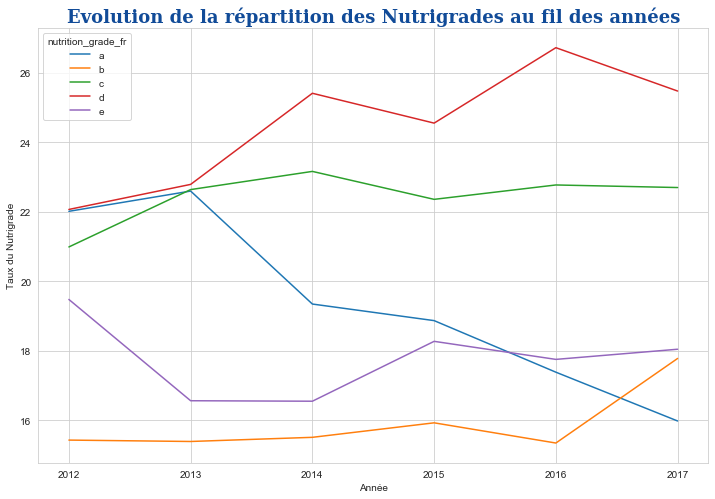

In [16]:
#On s'occupe ici uniquement des nutriscores et nutrigrades complétés
datas_nutri = datas[(datas['nutrition_grade_fr'].isnull()==False) & 
                   (datas['nutrition-score-fr_100g'].isnull()==False)]

ng_per_year = datas_nutri[['code','nutrition_grade_fr']].groupby(by=['nutrition_grade_fr',datas_nutri['created_datetime'].dt.year]).nunique().reset_index()
cum_per_year = datas_nutri[['code']].groupby(by=datas_nutri['created_datetime'].dt.year).nunique().reset_index()
ng_per_year = pd.merge(ng_per_year, cum_per_year, how="left", left_on="created_datetime", right_on="created_datetime")
ng_per_year = ng_per_year.rename(columns={'created_datetime':'year', 'code_x':'nb_nutrigrade', 'code_y':'total_grade'})
ng_per_year['nutrigrade_rate'] = (ng_per_year['nb_nutrigrade'] / ng_per_year['total_grade'])*100

fig =plt.figure(figsize=(12,8))
ax = sns.lineplot(x='year', y='nutrigrade_rate', hue='nutrition_grade_fr', data=ng_per_year)
plt.xlabel("Année")
plt.ylabel("Taux du Nutrigrade")
plt.title("Evolution de la répartition des Nutrigrades au fil des années", fontdict=font_title)
plt.show()

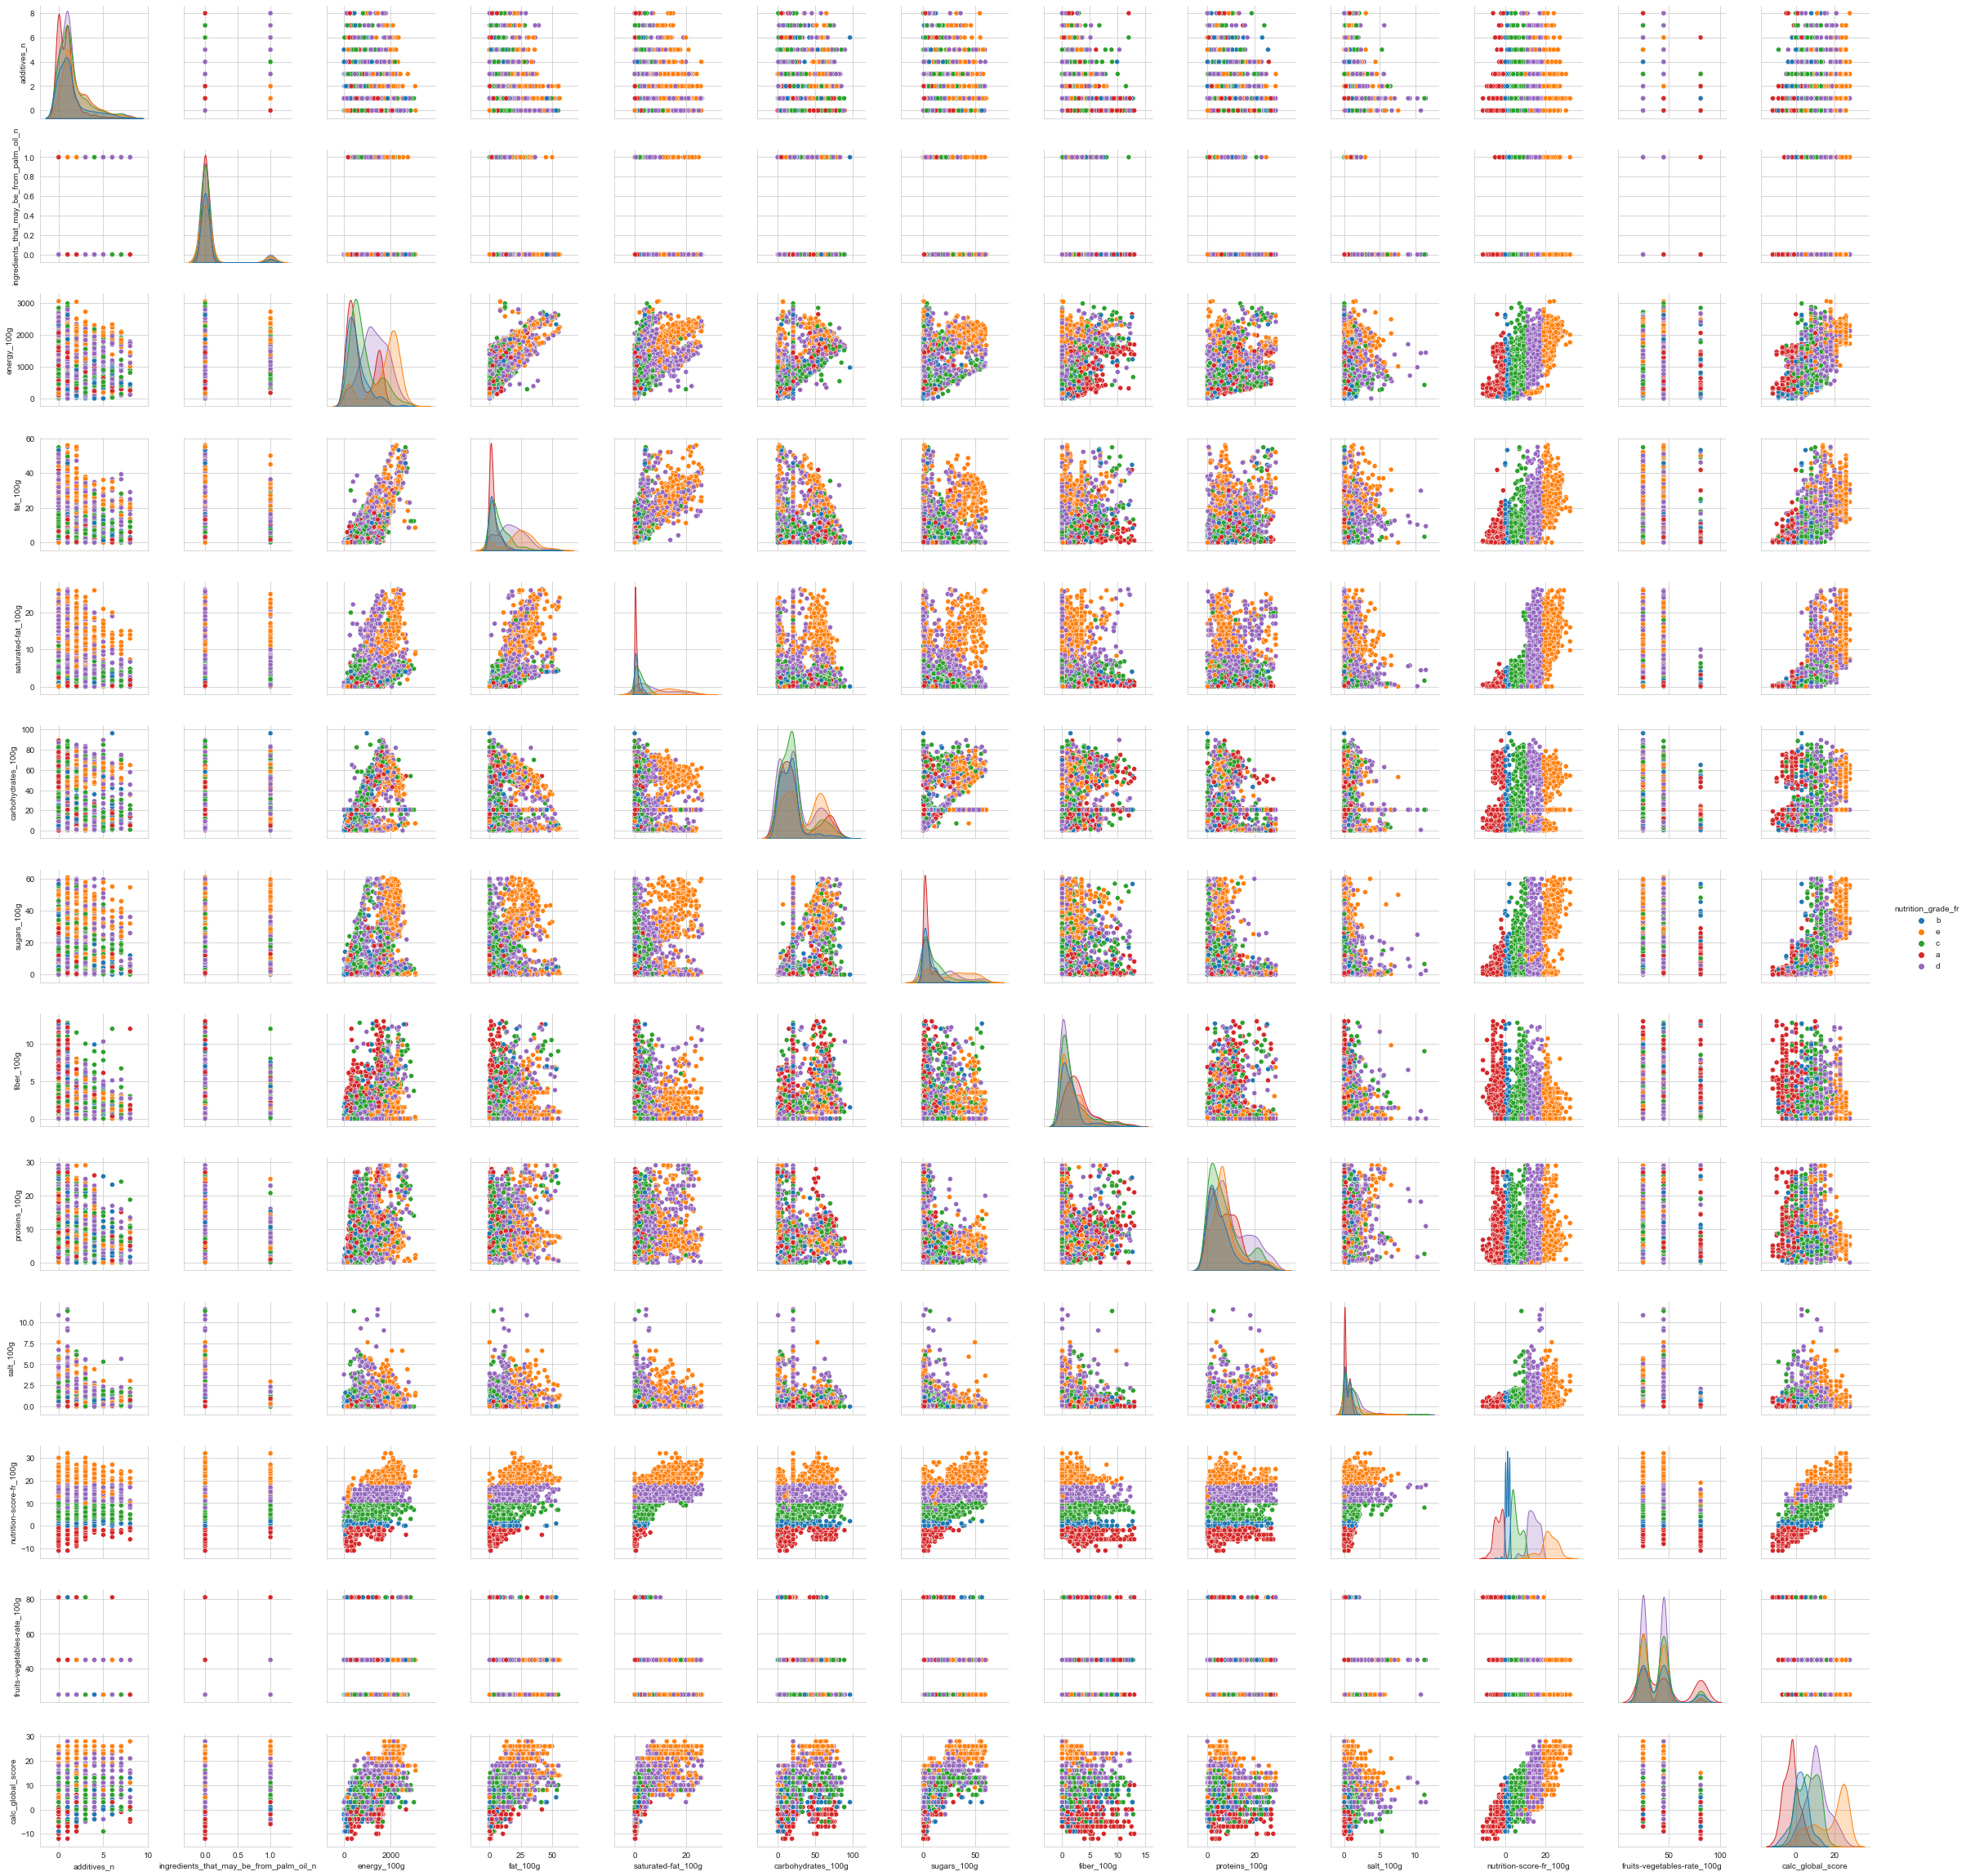

In [17]:
sns.pairplot(datas_nutri.sample(frac=0.05), hue="nutrition_grade_fr")

L'analyse de ces pairplots montre déjà des relations linéaires entre certaines variables. On remarque également le regroupement par Nutrigrade sur la plupart des features. Regardons à présent la répartition de ces Nutri-score et Nutri-grades

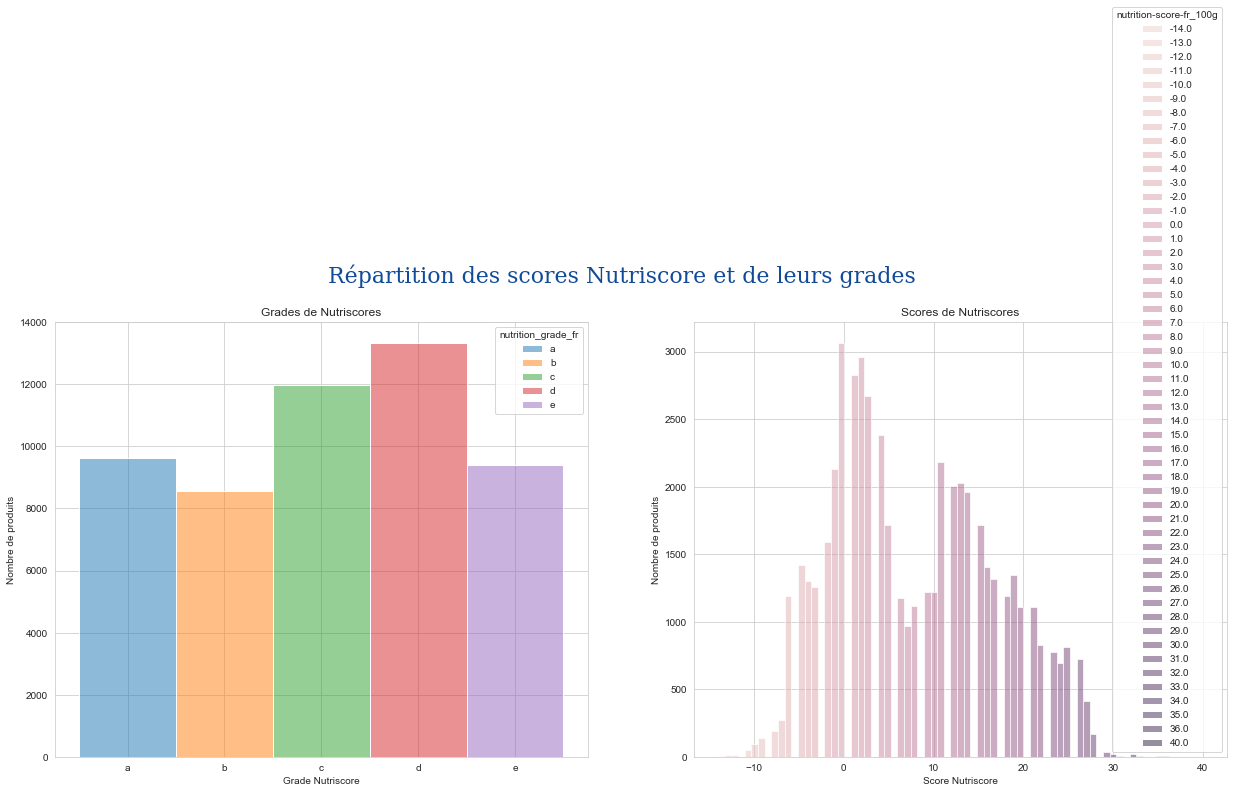

In [18]:
fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(21,8))
fig.suptitle(r"Répartition des scores Nutriscore et de leurs grades" "\n", fontdict=font_title, fontsize=22)

sns.histplot(data=datas_nutri.sort_values("nutrition_grade_fr"), x="nutrition_grade_fr", hue="nutrition_grade_fr", ax=axes[0])
axes[0].set_title('Grades de Nutriscores')
axes[0].set_xlabel("Grade Nutriscore")
axes[0].set_ylabel("Nombre de produits")

sns.histplot(data=datas_nutri.sort_values("nutrition-score-fr_100g"), x="nutrition-score-fr_100g", hue="nutrition-score-fr_100g", ax=axes[1])
axes[1].set_title('Scores de Nutriscores')
axes[1].set_xlabel("Score Nutriscore")
axes[1].set_ylabel("Nombre de produits")

plt.show()



La répartition des Nutriscores est quasi équitable avec tout de même une prépondérance pour la classe D. On peut également projeter la répartition des scores nutriscore par catégorie de produits (pnns_groups_1)

???


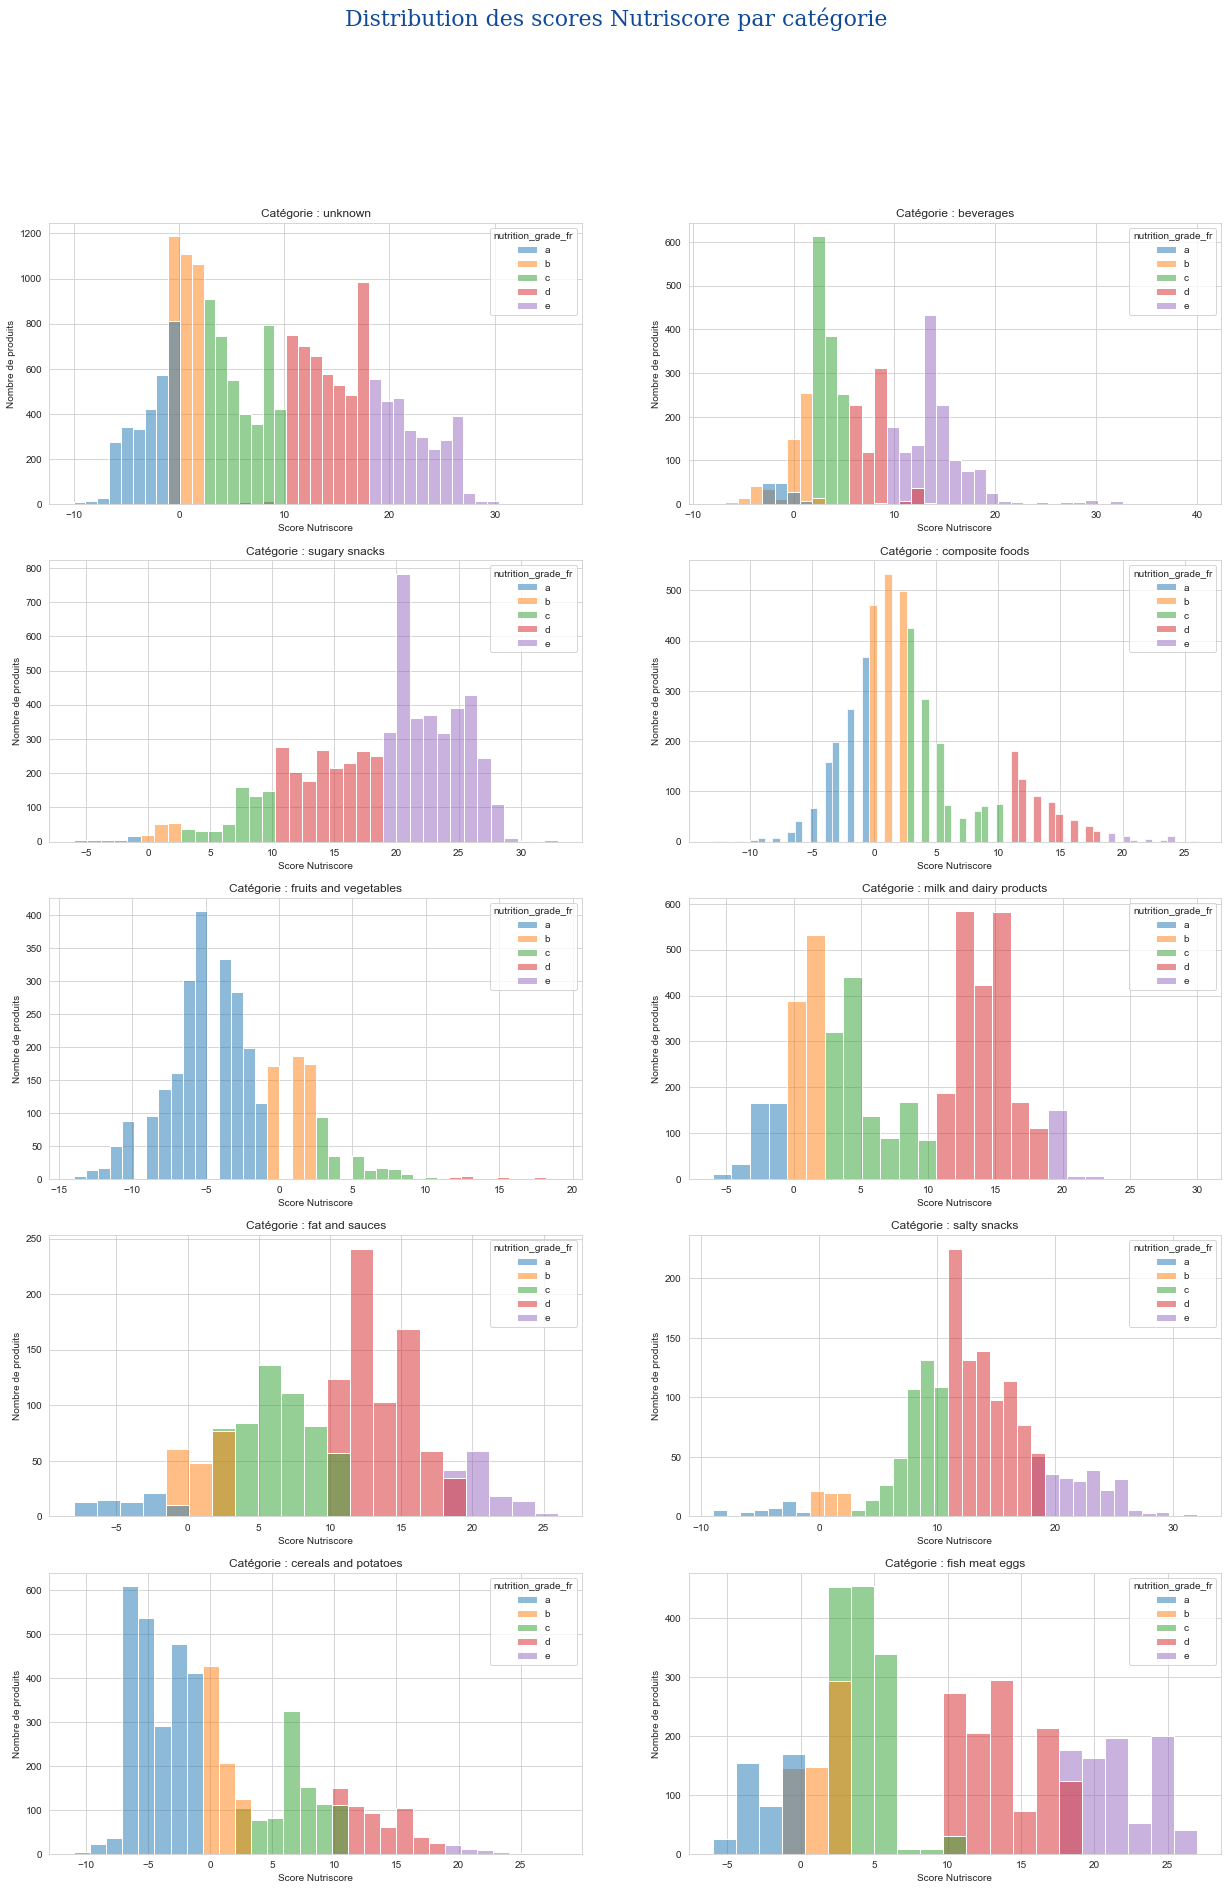

In [19]:
n_sub = len(datas_nutri['pnns_groups_1'].unique())
n_col = 2
fig, axes = plt.subplots(int(n_sub/n_col), n_col, sharex=False, sharey=False, figsize=(21,int(3*n_sub)))
axes = np.array(axes)
fig.suptitle("Distribution des scores Nutriscore par catégorie", fontdict=font_title, fontsize=22)
i=0
for ax in axes.reshape(-1):
    cat = datas_nutri['pnns_groups_1'].unique()[i]
    subset = datas_nutri[datas_nutri['pnns_groups_1']==cat].sort_values("nutrition_grade_fr")
    sns.histplot(data=subset, x="nutrition-score-fr_100g", hue="nutrition_grade_fr", ax=ax)
    ax.set_title('Catégorie : {}'.format(cat))
    ax.set_xlabel("Score Nutriscore")
    ax.set_ylabel("Nombre de produits")
    i+=1
plt.show()



Afin de vérifier si la catégorie pnns_groups_1 ou pnns_groups_2 influence rééllement le Nutriscore, nous pouvons réaliser une ANOVA (Analyse de la variance). Le choix de ce test est dû au fait que nous étudions 1 variable qualitative comparativement à une variable quantitative.

Les hypothèses posées seront donc les suivantes :

    H0 : La distribution des échantillons est similaire (et donc la catégorie n'a aucune influence sur le Nutriscore).
    H1 : Une ou plusieurs distributions sont inégales.

Pour commencer, nous pouvons projeter les boxplots de la répartition des nutriscores par catégorie pnns_groups_1 pour également vérifier les hypothèses de départ liées à l'ANOVA à savoir :

    Les observations dans chaque échantillon sont indépendantes et distribuées de manière identique (iid).
    Les observations dans chaque échantillon ont la même variance.
    Les observations de chaque échantillon sont normalement distribuées.



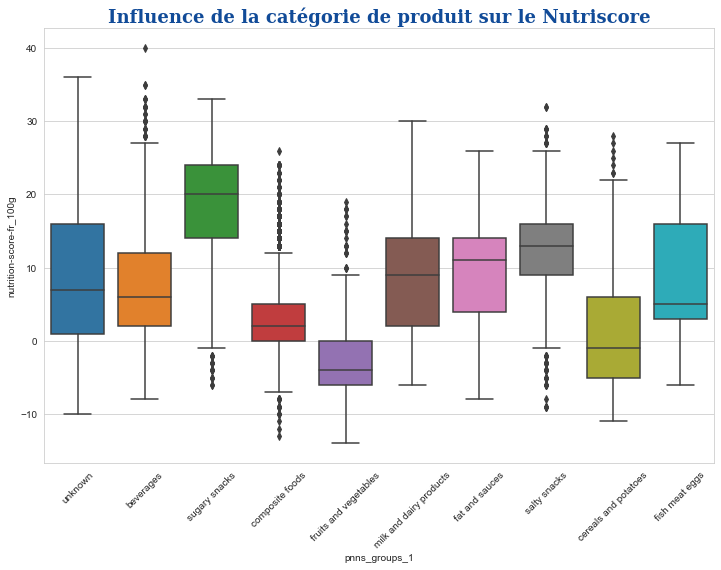

In [20]:
fig = plt.figure(figsize=(12,8))
ax = sns.boxplot(data=datas_nutri, x='pnns_groups_1', y='nutrition-score-fr_100g')
plt.setp(ax.get_xticklabels(), rotation=45)
plt.title("Influence de la catégorie de produit sur le Nutriscore", fontdict=font_title)
plt.show()



On remarque ici ques les catégories semblent assez différentes, même si l'ordre de grandeur des écart est relativement faible. Dans les histogrammes ci-dessus, nous voyons cependant que les distributions ne semblent pas suivre la loi normale.
La question sera à présent de savoir si ces écarts sont significatifs ou pas via l'analyse de variance :


In [21]:
datas.rename(columns={"nutrition-score-fr_100g": "nutritionscore100g"},inplace=True)

In [22]:
datas_nutri.rename(columns={"nutrition-score-fr_100g": "nutritionscore100g"},inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [23]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

anova_category = smf.ols('nutritionscore100g~pnns_groups_1', data=datas_nutri).fit()
print(anova_category.summary())

                            OLS Regression Results                            
Dep. Variable:     nutritionscore100g   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.327
Method:                 Least Squares   F-statistic:                     2851.
Date:                Fri, 01 Apr 2022   Prob (F-statistic):               0.00
Time:                        15:36:27   Log-Likelihood:            -1.8064e+05
No. Observations:               52871   AIC:                         3.613e+05
Df Residuals:                   52861   BIC:                         3.614e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [24]:
#Tableau d'analyse de variance
sm.stats.anova_lm(anova_category, typ=2)

sum_sq       df            F  PR(>F)
pnns_groups_1  1.394542e+06      9.0  2850.934604     0.0
Residual       2.873010e+06  52861.0          NaN     NaN

Les résultats du test de Fisher nous indiquent ici une p-value de 0 pour l'ensemble des catégories, donc inferieur au niveau de test de 5%. Nous rejettons donc l'hypothèse H0 selon laquelle les ditributions sont identiques.
La catégorie de produit a donc bien une influence sur le Nutriscore.


# 1.4. Analyse des corrélations linéaires

Pour analyser les corrélations linéaires entre nos variables quantitatives, nous allons réaliser un test de corrélation de Pearson et afficher ses résultats dans un heatmap :


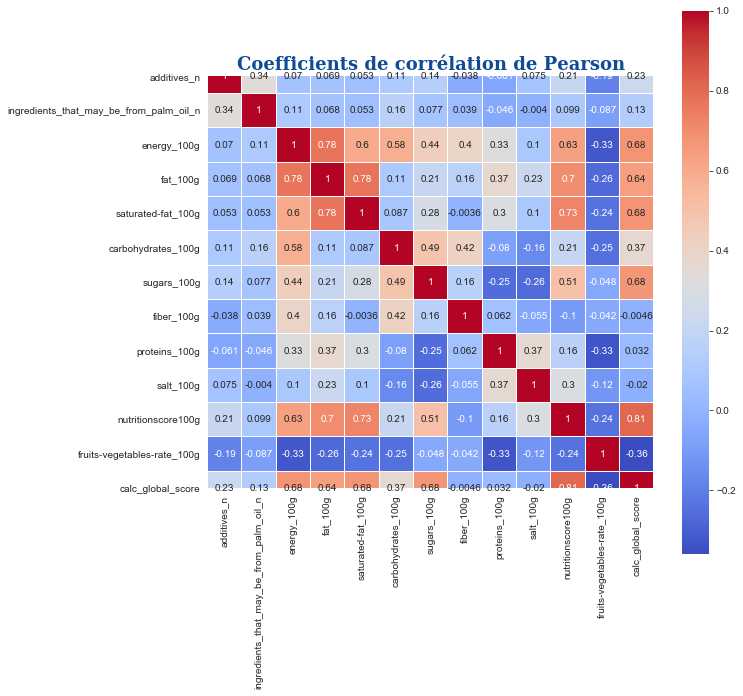

In [25]:
#Matrice des corrélations
corr_mat = datas_nutri.corr()
#heatmap
fig = plt.figure(figsize=(10,10))
sns.heatmap(corr_mat, square=True, linewidths=0.01, annot=True, cmap='coolwarm')
plt.title("Coefficients de corrélation de Pearson", fontdict=font_title)
plt.show()

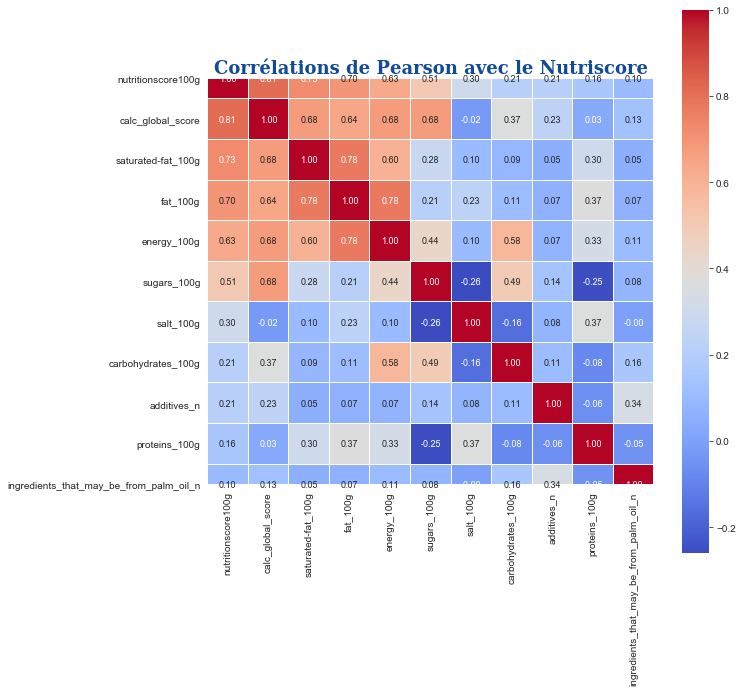

In [26]:
fig = plt.figure(figsize=(10,10))
cols = corr_mat.nlargest(11,'nutritionscore100g')['nutritionscore100g'].index
corr_nutriscore = corr_mat.loc[cols, cols]
sns.heatmap(corr_nutriscore, cbar=True, annot=True,
            fmt='.2f', annot_kws={'size': 9},
            square=True, linewidths=0.01, cmap='coolwarm')
plt.title("Corrélations de Pearson avec le Nutriscore", fontdict=font_title)
plt.show()

Logiquement, les variables utilisées dans le calcul des nutriscore sont bien corrélées linéairement à ce dernier.
Nous allons vérifier si cette théorie fonctionne grâce à la régression linéaire multivariée.

# 2. Analyses multivariées : Régression linéaire multivariée.

Quand une variable cible est le fruit de la corrélation de plusieurs variables prédictives, on parle de Multivariate Regression pour faire des prédictions. Toutes ces variables prédictives seront utilisées dans notre modèle de régression linéaire multivariée pour trouver une fonction prédictive du type :
F(X)=ϵ+αx1+βx2+γx3+...+ωxn

où :

    ϵ

est une constante,
α,β,γ
représentent les coefficients de notre fonction prédictive F(X)
,
X

    est un vecteur de variables prédictives.

Dans un premier temps, nous allons considérer comme variables prédictives uniquement l'ensemble des variables numériques. Nous étenderons par la suite le modèle aux variables catégorielles.

In [27]:
# Nous partons du dataset dont les nutriscores sont complétés.
numerical_features = datas_nutri.select_dtypes(include=['float64','int64'])

y = numerical_features['nutritionscore100g'].values
X = numerical_features.drop('nutritionscore100g', axis=1)

In [28]:
numerical_features.columns

Index(['additives_n', 'ingredients_that_may_be_from_palm_oil_n', 'energy_100g',
       'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g',
       'fiber_100g', 'proteins_100g', 'salt_100g', 'nutritionscore100g',
       'fruits-vegetables-rate_100g', 'calc_global_score'],
      dtype='object')

Nous devons ici supprimer les variables fortement corrélées à savoir : sodium_100g, carbohydrates_100g et fat_100g

In [29]:
X.drop(['carbohydrates_100g','fat_100g'], axis=1, inplace=True)

Nous allons devoir standardiser nos données afin de les placer sur la même echèle (moyenne = 0 et écart-type = 1)

In [30]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

Puis nous allons spliter nos données en 1 jeu d'entrainement et un jeu de test (30%) :

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# 2.1. Baseline

Nous avons donc à notre disposition un jeu d'entrainement et un jeu de test pour nos prédictions du Nutriscore. Comme dans toute approche de modélisation, nous allons devoir vérifier que notre modèle est réellement performant. La régression linéaire étant un modèle relativement simple, nous allons devoir réaliser une baseline. Nous utiliserons la méthode DummyRegressor de la librairie Sklearn :

In [32]:
from sklearn.dummy import DummyRegressor
dummy_reg = DummyRegressor(strategy="mean")
dummy_reg.fit(X_train, y_train)
dummy_pred = dummy_reg.predict(X_test)

Nous allons calculer plusieurs métriques pour cette baseline :

In [33]:
def metrics_model(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    diff = y_true - y_pred
    mae = np.mean(abs(diff))
    mse = np.mean(diff**2)
    rmse = np.sqrt(mse)
    r2 = 1-(sum(diff**2)/sum((y_true-np.mean(y_true))**2))
    dict_metrics = {"Métrique":["MAE", "MSE", "RMSE", "R²"], "Résultats":[mae, mse, rmse, r2]}
    df_metrics = pd.DataFrame(dict_metrics)
    return df_metrics

In [34]:
dummy_metrics = metrics_model(y_test, dummy_pred).rename(columns={'Résultats':'Baseline'})
dummy_metrics

Métrique   Baseline
0      MAE   7.844349
1      MSE  82.083512
2     RMSE   9.059995
3       R²  -0.000042


# 2.2. première régression linéaire

Nous avons donc nos métriques de Baseline et nous allons à présent pouvoir réaliser notre premier modèle de régression linéaire multivariée et le comparer aux métriques de base obtenues :


In [35]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

In [36]:
lr_metrics = metrics_model(y_test, lr_pred).rename(columns={'Résultats':'LinearRegression'})
lr_metrics = pd.concat([dummy_metrics,lr_metrics['LinearRegression']], axis=1)
lr_metrics

Métrique   Baseline  LinearRegression
0      MAE   7.844349          2.717468
1      MSE  82.083512         13.176506
2     RMSE   9.059995          3.629946
3       R²  -0.000042          0.839468

Les métriques de ce premier modèle sont bien meilleurs que la baseline. Le R² (coefficient de détermination) qui est le carré du coefficient de corrélation linéaire, est de 0.64 ce qui en fait une base correcte de prédiction. Nous pouvons d'ailleurs projeter les erreurs de prédictions :

In [37]:
def plot_pred_true(y_true, y_pred):
    X_plot = [y_true.min(), y_true.max()]
    fig = plt.figure(figsize=(12,8))
    plt.scatter(y_true, y_pred)
    plt.plot(X_plot, X_plot, color='r')
    plt.xlabel("Valeurs réélles")
    plt.ylabel("Valeurs prédites")
    plt.title("Projection des valeurs prédites en fonction des valeurs réélles", fontdict=font_title, fontsize=18)
    plt.show()


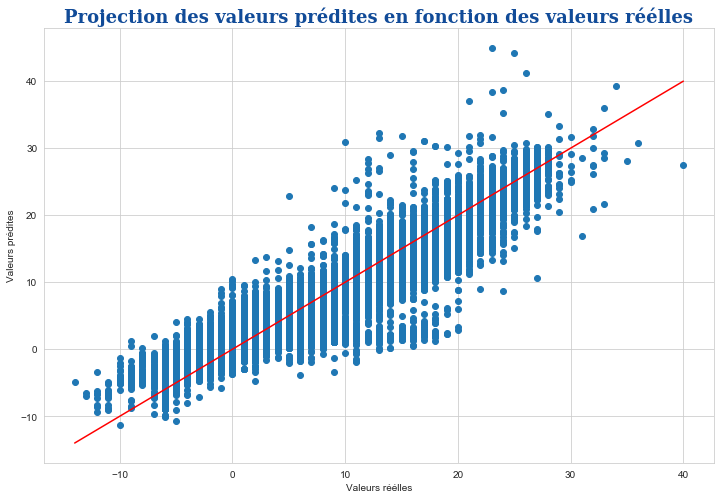

In [38]:
plot_pred_true(y_true=y_test, y_pred=lr_pred)

On remarque une dispersion encore importante des prédictions aux valeurs test. Ce premier modèle peut être amélioré, par exemple en ajoutant la catégorie du produit.

# 2.3. Régression linéaire avec catégorie produits

Ajoutons à présent dans le modèle les 2 principales variables de catégorisation de produits : pnns_groups_1, pnns_groups_2. Ces variables catégorielles vont devoir être encodées pour être incorporées au modèle. Pour cette modélisattion, nous allons réaliser un OneHotEncoder.


In [39]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numerical_features = list(X.columns)
numerical_transformer = StandardScaler()

categorical_features = list(['pnns_groups_1', 'pnns_groups_2'])
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor),
                             ('regressor', LinearRegression())])

X = datas_nutri[numerical_features + categorical_features]
y = datas_nutri['nutritionscore100g']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42)

pipeline_lr.fit(X_train, y_train)
plr_pred = pipeline_lr.predict(X_test)

plr_metrics = metrics_model(y_test, plr_pred).rename(columns={'Résultats':'LinearRegression cat'})
plr_metrics = pd.concat([lr_metrics,plr_metrics['LinearRegression cat']], axis=1)
plr_metrics



Métrique   Baseline  LinearRegression  LinearRegression cat
0      MAE   7.844349          2.717468              2.107047
1      MSE  82.083512         13.176506              7.641011
2     RMSE   9.059995          3.629946              2.764238
3       R²  -0.000042          0.839468              0.906908

In [41]:
from sklearn import set_config

set_config(display='diagram')
pipeline_lr

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['additives_n',
                                                   'ingredients_that_may_be_from_palm_oil_n',
                                                   'energy_100g',
                                                   'saturated-fat_100g',
                                                   'sugars_100g', 'fiber_100g',
                                                   'proteins_100g', 'salt_100g',
                                                   'fruits-vegetables-rate_100g',
                                                   'calc_global_score']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['pnns_groups_1',
                                                   'pnns_groups_2'])])),
                ('regressor', LinearRegression())])



Les métriques pour ce second modèle sont meilleures que le premier modèle simple de régression linéaire. En effet, nous avons vu préalablement que l'hypothèse selon laquelle la catégorie influençait le Nutriscore était vérifiée.

Pour améliorer encore les performances, nous pourrions traiter d'autres types d'algorithmes comme la régression Ridge par exemple ou encore la régression lasso.

Nous allons à présent faire une réduction de dimensions afin de trouver les meilleurs plans factoriels du jeu de données.



# 3. Réduction dimensionnelle.¶

Pour cette réduction du nombre de dimensions, nous allons réaliser une Analyse en Composantes Principale (PCA), l'une des méthodes d'analyse de données multivariées les plus utilisées. Elle permet d'explorer des jeux de données multidimensionnels constitués de variables quantitatives.

Pour cela, nous utiliserons la méthode PCA du module decomposition Sklearn sur les variables numériques centrées et réduite. Nous prendrons en variable illustrative de cette ACP le grade Nutriscore du produit.


In [42]:
from sklearn.decomposition import PCA

#Centrage et réduction
X = datas_nutri.select_dtypes(include=['float64','int64'])
X_scaled = scaler.fit_transform(X)

#Instanciation de l'ACP
pca = PCA(svd_solver='full').fit(X_scaled)
X_projected = pca.transform(X_scaled)


# 3.1. Eboulis des valeurs propres¶

Afin d'avoir un aperçu du nombre de composantes nécessaire à l'analyse, nous allons projeter l'éboulis des valeurs propres :


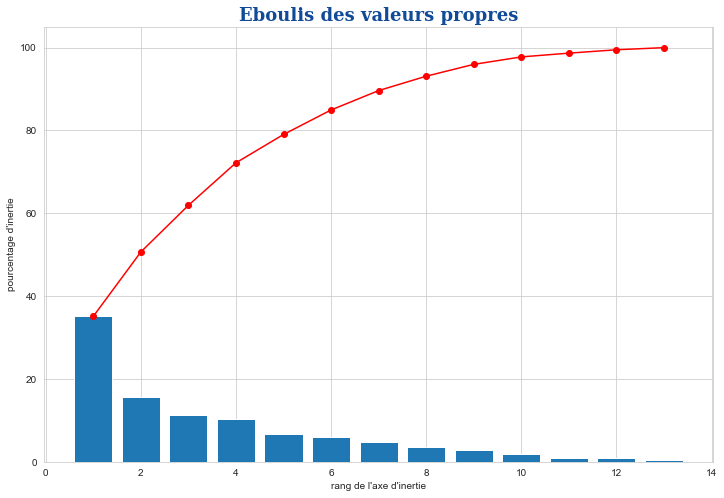

In [43]:
#Variances expliquées
varexpl = pca.explained_variance_ratio_*100

#Projection de l'éboulis des valeurs propres
plt.figure(figsize=(12,8))
plt.bar(np.arange(len(varexpl))+1, varexpl)
plt.plot(np.arange(len(varexpl))+1, varexpl.cumsum(),c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres", fontdict=font_title)
plt.show(block=False)

In [44]:
print("Le premier plan factoriel couvrira une inertie de {:.2f}% et le second plan : {:.2f}%.".format(varexpl[0:2].sum(),
                                                                                                     varexpl[0:4].sum()))


Le premier plan factoriel couvrira une inertie de 50.66% et le second plan : 72.20%.


Une analyse sur F1 et F2

semble donc cohérente.

Projetons à présent le cercle des corrélations :

# 3.2. Cercle des corrélations

In [45]:
#Espace des composantes principales
pcs = pca.components_

#Matrice des corrélations variables x facteurs
p = X.shape[1]
sqrt_valprop = np.sqrt(pca.explained_variance_)
corvar = np.zeros((p, p))
for dim in range(p):
    corvar[:,dim] = pcs[dim,:] * sqrt_valprop[dim]

#on affiche pour les deux premiers plans factoriels 
corr_matrix = pd.DataFrame({'feature':X.columns,'CORR_F1':corvar[:,0],'CORR_F2':corvar[:,1], 
              'CORR_F3':corvar[:,2], 'CORR_F4':corvar[:,3]})
corr_matrix


feature   CORR_F1   CORR_F2   CORR_F3  \
0                               additives_n  0.225334 -0.141628 -0.391551   
1   ingredients_that_may_be_from_palm_oil_n  0.173622 -0.195862 -0.198124   
2                               energy_100g  0.881994 -0.050285  0.335994   
3                                  fat_100g  0.828716  0.317257  0.054516   
4                        saturated-fat_100g  0.792638  0.262407 -0.146941   
5                        carbohydrates_100g  0.464139 -0.590859  0.401176   
6                               sugars_100g  0.569885 -0.621176 -0.177233   
7                                fiber_100g  0.196078 -0.309393  0.764072   
8                             proteins_100g  0.281873  0.678593  0.387959   
9                                 salt_100g  0.150456  0.653896  0.023040   
10                       nutritionscore100g  0.858805  0.131762 -0.327336   
11              fruits-vegetables-rate_100g -0.432351 -0.166875 -0.163276   
12                        calc_global_score  0.886077 -0.165561 -0.270559   

     CORR_F4  
0   0.677803  
1   0.670388  
2  -0.025880  
3  -0.131337  
4  -0.230567  
5   0.171609  
6  -0.206208  
7   0.103371  
8   0.148913  
9   0.247228  
10 -0.112814  
11 -0.406485  
12 -0.107369

In [47]:
#Variable Illustrative
ivNutrigrade = datas_nutri['nutrition_grade_fr'].values

#Encodage des grades
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
ivNutrigrade = encoder.fit_transform(ivNutrigrade)
ivNutrigrade = ivNutrigrade.reshape((ivNutrigrade.shape[0],1))

#Corrélation de la variable illustrative avec les axes factoriels 
corrIv = np.zeros((ivNutrigrade.shape[1],p))
for j in range(p): 
    for k in range(ivNutrigrade.shape[1]): 
        corrIv[k,j] = np.corrcoef(ivNutrigrade[:,k],X_projected[:,j])[0,1]



In [48]:
def cerle_corr(pcs, n_comp, pca, axis_ranks, 
               labels=None, label_rotation=0, 
               illustrative_var_label=None, illustrative_var_corr=None):
    for d1, d2 in axis_ranks:
        if d2 < n_comp:
            
            # initialisation de la figure
            fig=plt.figure(figsize=(10,10))
            fig.subplots_adjust(left=0.1,right=0.9,bottom=0.1,top=0.9)
            ax=fig.add_subplot(111)
            ax.set_aspect('equal', adjustable='box') 

            #détermination des limites du graphique
            ax.set_xlim(-1,1) 
            ax.set_ylim(-1,1) 

            #affichage des flèches 
            plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                       pcs[d1,:],pcs[d2,:], 
                       angles='xy', scale_units='xy', scale=1, 
                       color="grey", alpha=0.5)
            # et noms de variables
            for i,(x,y) in enumerate(pcs[[d1,d2]].T):
                plt.annotate(labels[i],(x,y),
                             ha='center', va='center',
                             fontsize='14',color="#17aafa", alpha=0.8) 

            #variable illustrative
            if illustrative_var_label is not None :
                plt.annotate(illustrative_var_label,
                             (illustrative_var_corr[0,d1],illustrative_var_corr[0,d2]),
                             color='g')
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                                   illustrative_var_corr[0,d1],illustrative_var_corr[0,d2], 
                                   angles='xy', scale_units='xy', scale=1, color="g", alpha=0.5)

            #ajouter les axes 
            plt.plot([-1,1],[0,0],linewidth=1, color='grey', ls='--') 
            plt.plot([0,0],[-1,1],linewidth=1, color='grey', ls='--')

            #ajouter un cercle 
            cercle = plt.Circle((0,0),1,color='#17aafa',fill=False) 
            ax.add_artist(cercle) 

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1), fontdict=font_title)
            plt.show(block=False)


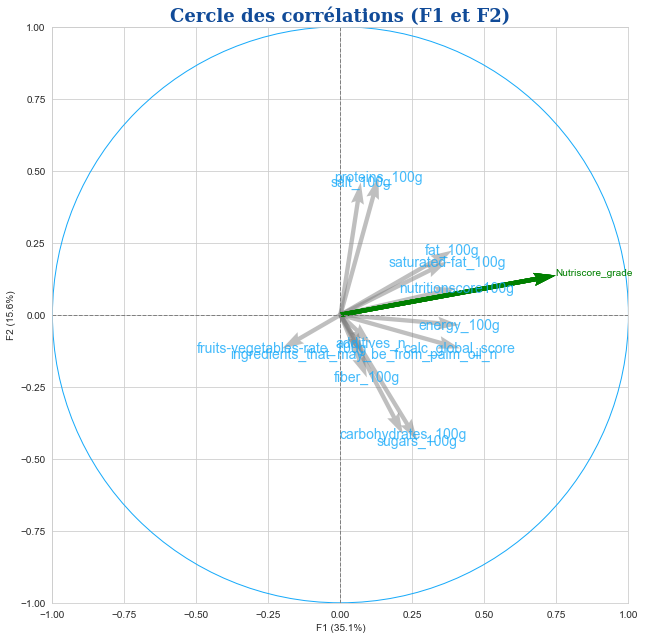

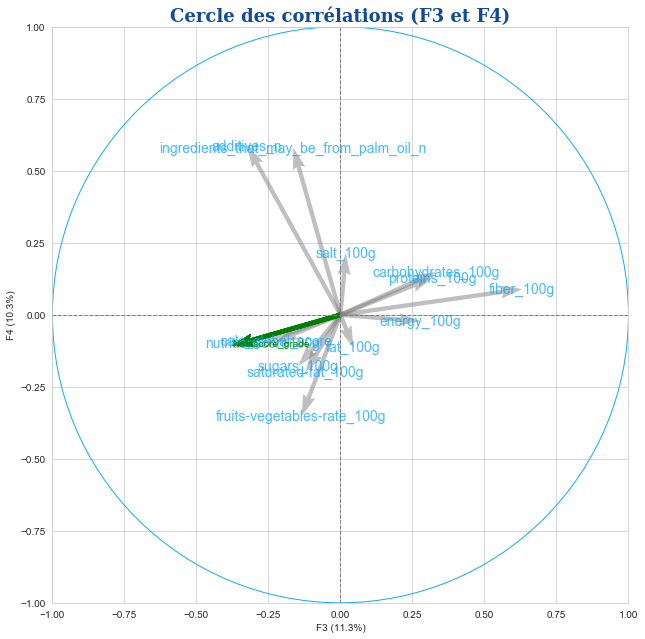

In [49]:
cerle_corr(pcs, 4, pca, [(0,1),(2,3)], labels = np.array(X.columns), 
           illustrative_var_label="Nutriscore_grade", illustrative_var_corr = corrIv)


# 3.3. Projection des produits sur les plans factoriels¶

On peut à présent visualiser la projection des individus sur ces premiers plans factoriels et donc en 2D :


In [50]:
def plot_plans_factoriels(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(12,8))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
            
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des {} individus sur F{} et F{}".format(X_projected.shape[0], d1+1, d2+1), fontdict=font_title)
            plt.show(block=False)


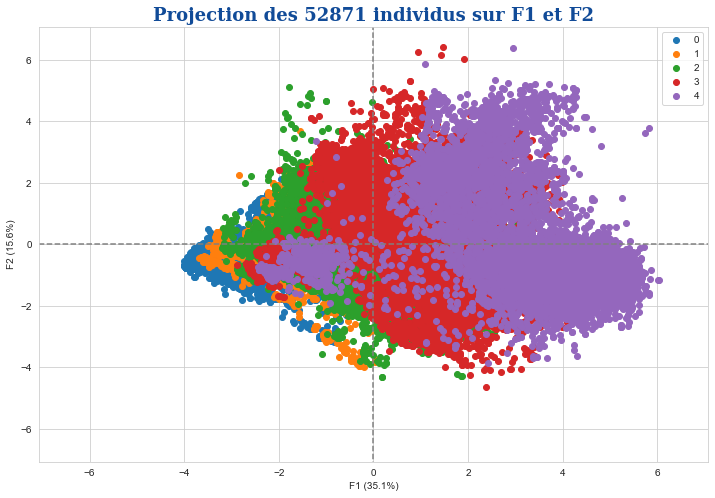

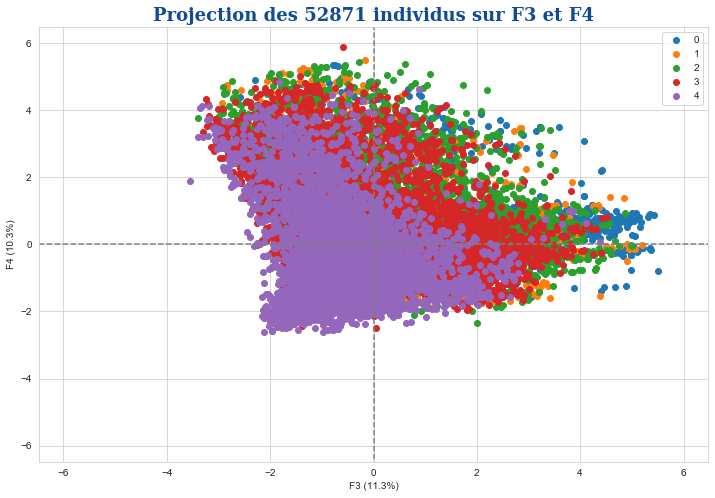

In [49]:
plot_plans_factoriels(X_projected, 4, pca, [(0,1),(2,3)], illustrative_var = ivNutrigrade)

# 3.4. Qualité de représentation de la réduction de dimension¶

Afin d'analyser la performance de notre réduction de dimension via PCA, nous allons regarder le COS² et la CTR*.

On peut calculer la qualité de représentation des variables (COS²) en élevant la corrélation au carré :


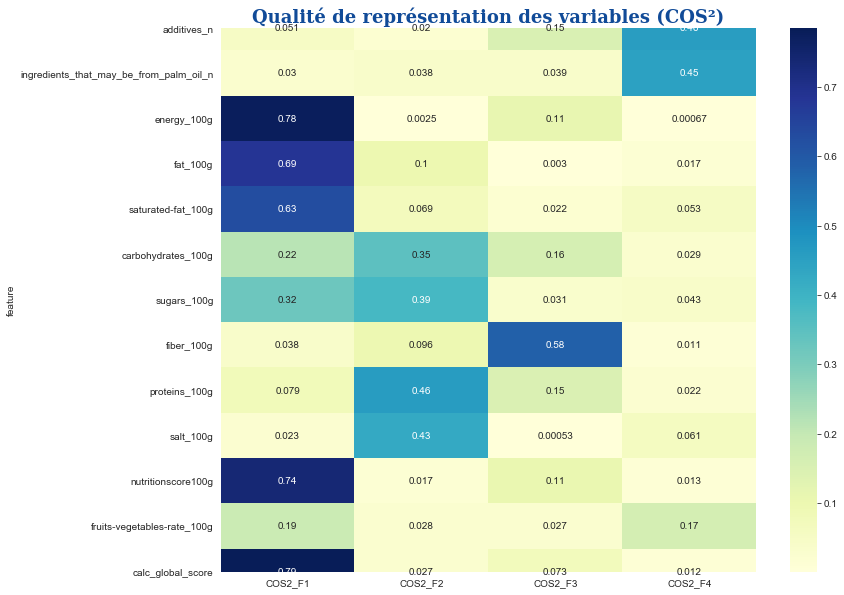

In [51]:
#Calcul des COS²
cos2var = corvar**2
df_cos2var = pd.DataFrame({'feature':X.columns,'COS2_F1':cos2var[:,0],
                           'COS2_F2':cos2var[:,1], 'COS2_F3':cos2var[:,2],
                           'COS2_F4':cos2var[:,3]}).set_index('feature')

#affichage dans un heatmap seaborn
fig = plt.figure(figsize=(12,10))
sns.heatmap(df_cos2var, annot=True, cmap="YlGnBu")
plt.title("Qualité de représentation des variables (COS²)", fontdict=font_title)
plt.show()

On remarque ici clairement, avec le cercle et le COS², les corrélations importantes entre l'energie et le caractère "gras" des produits. L'axe F1 va donc parfaitement représenter le facteur "énergétique" et l'axe F2 quant à lui représentera bien les qualités "sucré / salé".

Regardons à présent la contribution des variables aux axes (CTR), elle aussi également basée sur le carré de la corrélation, mais relativisée par l’importance de l’axe :

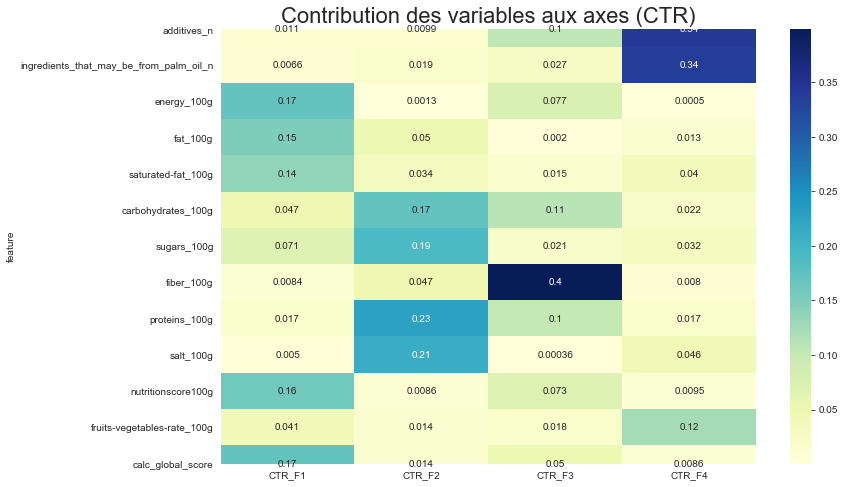

In [52]:
#contributions 
ctrvar = cos2var 
for k in range(p): 
    ctrvar[:,k] = ctrvar[:,k]/pca.explained_variance_[k] 

df_ctrvar = pd.DataFrame({'feature':X.columns,'CTR_F1':ctrvar[:,0],'CTR_F2':ctrvar[:,1],
                         'CTR_F3':ctrvar[:,2], 'CTR_F4':ctrvar[:,3]}).set_index('feature')

#affichage dans un heatmap seaborn
fig = plt.figure(figsize=(12,8))
sns.heatmap(df_ctrvar, annot=True, cmap="YlGnBu")
plt.title("Contribution des variables aux axes (CTR)", fontsize=22)
plt.show()

Afin de tester une dernière modélisation à partir des variables synthétiques F1 à F4, nous allons les ajouter à notre dataset initial :

In [53]:
df_syn_var = pd.DataFrame(X_projected[:,:4], index=datas_nutri.index, 
                          columns=["F"+str(i+1) for i in range(4)])
datas_extend = pd.concat([datas_nutri, df_syn_var], axis=1)
datas_extend.head()

code                                                url  creator  \
0     36252  http://world-fr.openfoodfacts.org/produit/0000...  tacinte   
4  10207260  http://world-fr.openfoodfacts.org/produit/0000...  kiliweb   
5  40608754  http://world-fr.openfoodfacts.org/produit/0000...    andre   
6  69161025  http://world-fr.openfoodfacts.org/produit/0000...  kiliweb   
7  87177756  http://world-fr.openfoodfacts.org/produit/0000...   tacite   

     created_datetime last_modified_datetime                product_name  \
0 2015-01-25 21:35:01    2017-03-09 10:34:27              Lion Peanut x2   
4 2017-03-22 17:17:11    2017-03-22 17:29:17  Praliné Amande Et Noisette   
5 2012-08-15 09:48:28    2015-08-09 17:35:31       Pepsi, Nouveau goût !   
6 2017-03-22 19:59:36    2017-03-22 19:59:36   Tarte Poireaux Et Lardons   
7 2015-06-06 10:28:06    2015-06-06 11:13:26                         7Up   

  quantity          packaging        brands  \
0      NaN                NaN      Sunridge   
4      NaN                NaN  Alice Délice   
5    15 cl  Canette aluminium         Pepsi   
6      NaN                NaN      Bo Frost   
7    33 cl            Canette   7Up,Pepsico   

                                       categories_fr  ... proteins_100g  \
0                                            unknown  ...           2.5   
4                                            unknown  ...           9.5   
5  Boissons,Boissons gazeuses,Sodas,Sodas au cola...  ...           0.0   
6                                            unknown  ...           7.5   
7  Aliments et boissons à base de végétaux,Boisso...  ...           0.0   

  salt_100g nutritionscore100g  fruits-vegetables-rate_100g calc_global_score  \
0   0.09652               22.0                           45                24   
4   0.00300               14.0                           45                13   
5   0.02540               13.0                           45                 3   
6   0.80000               15.0                           45                 9   
7   0.10000               13.0                           45                 3   

   calc_nutriscore        F1        F2        F3        F4  
0                e  3.650233 -2.588004 -0.436117 -1.616360  
4                d  2.432178 -1.211095  0.569113 -1.291814  
5                b -1.605073 -0.659513 -1.523709 -0.297795  
6                c  0.720235  0.802939 -0.352499 -0.780875  
7                b -1.537955 -0.687109 -1.713636  0.063373  

[5 rows x 39 columns]

In [54]:
datas_extend.columns

Index(['code', 'url', 'creator', 'created_datetime', 'last_modified_datetime',
       'product_name', 'quantity', 'packaging', 'brands', 'categories_fr',
       'countries_fr', 'ingredients_text', 'serving_size', 'additives_n',
       'additives_fr', 'ingredients_that_may_be_from_palm_oil_n',
       'nutrition_grade_fr', 'pnns_groups_1', 'pnns_groups_2', 'states_fr',
       'main_category_fr', 'image_url', 'image_small_url', 'energy_100g',
       'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g',
       'fiber_100g', 'proteins_100g', 'salt_100g', 'nutritionscore100g',
       'fruits-vegetables-rate_100g', 'calc_global_score', 'calc_nutriscore',
       'F1', 'F2', 'F3', 'F4'],
      dtype='object')

In [55]:
#Les variables synthétiques sont déjà standardisées
numerical_features = ['F1','F2','F3','F4']

categorical_features = list(['pnns_groups_1', 'pnns_groups_2'])
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)])

pipeline_lr_pca = Pipeline(steps=[('preprocessor', preprocessor),
                             ('regressor', LinearRegression())])

X = datas_extend[numerical_features + categorical_features]
y = datas_extend['nutritionscore100g']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42)

pipeline_lr_pca.fit(X_train, y_train)
plr_pca_pred = pipeline_lr_pca.predict(X_test)

plr_pca_metrics = metrics_model(y_test, plr_pca_pred).rename(columns={'Résultats':'LinearRegression PCA'})
plr_pca_metrics = pd.concat([plr_metrics,plr_pca_metrics['LinearRegression PCA']], axis=1)
plr_pca_metrics

Métrique   Baseline  LinearRegression  LinearRegression cat  \
0      MAE   7.844349          2.717468              2.107047   
1      MSE  82.083512         13.176506              7.641011   
2     RMSE   9.059995          3.629946              2.764238   
3       R²  -0.000042          0.839468              0.906908   

   LinearRegression PCA  
0              5.445194  
1             47.813385  
2              6.914722  
3              0.417479

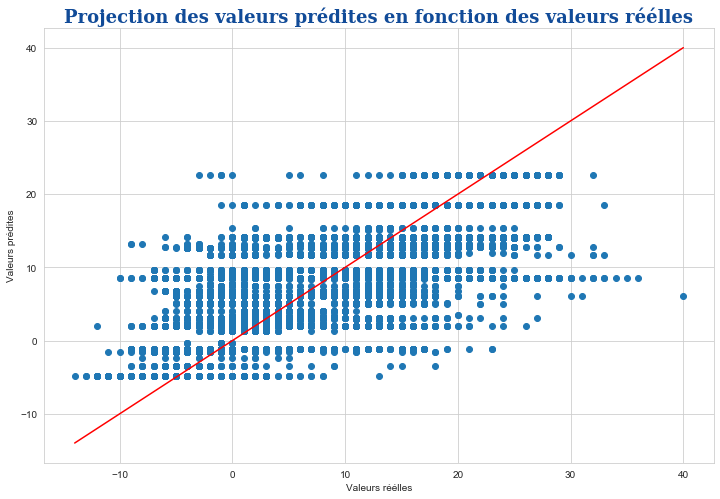

In [56]:
plot_pred_true(y_true=y_test, y_pred=plr_pca_pred)